# Trabajo Práctico N3. Procesamiento de Imágenes

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import scipy
import scipy.signal
import scipy.fft as fft
from PIL import Image
from math import pi

In [2]:
def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255):
    fig, axes = plt.subplots(1, len(imgs))
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

### 1)

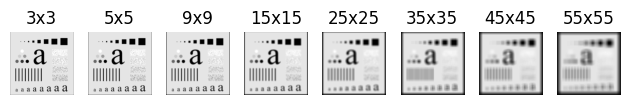

In [3]:
def normalize_mask(mask):
    return mask / np.sum(mask)

def uniform_mask(shape):
    return normalize_mask(np.ones(shape))

def gaussian_mask(shape, sigma=1):
    h1, h2 = shape[0] - 1, shape[1] - 1
    x, y = np.meshgrid(np.arange(0, h2+1), np.arange(0, h1+1))
    x = x - h2/2
    y = y - h1/2
    gauss = 1/(2 * pi * sigma**2) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    f = gauss
    return normalize_mask(f)
    # return f

# print(gaussian_mesh((7, 7)))

img_test = cv2.imread("images/characters_test_pattern.tif", cv2.IMREAD_GRAYSCALE)
img_test = img_test / 255

imgs = []
sizes = (3, 5, 9, 15, 25, 35, 45, 55)
for size in sizes:
    shape = (size, size)
    filter = uniform_mask(shape)

    imgs.append(scipy.signal.convolve2d(img_test, filter))

show_side_by_side(imgs, [f"{size}x{size}" for size in sizes], vmax=1)

### 2)

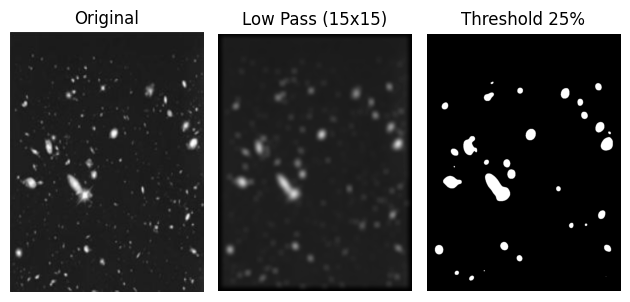

In [4]:
stars_img = cv2.imread("images/stars.png", cv2.IMREAD_GRAYSCALE)
# show_side_by_side([uniform_mask((15, 15)), gaussian_mask((15, 15), sigma=10)], ['uniform', 'gaussian'], vmax=0.01)
# print(gaussian_mask((15, 15)))
low_pass = scipy.signal.convolve2d(stars_img, gaussian_mask((31, 31), sigma=10))
# low_pass = scipy.signal.convolve2d(stars_img, uniform_mask((21, 21)))
threshold = low_pass.copy()
threshold_val = .25 * 256
threshold[threshold < threshold_val] = 0
threshold[threshold >= threshold_val] = 255
show_side_by_side([stars_img, low_pass, threshold], ["Original", "Low Pass (15x15)", "Threshold 25%"])

### 3)

Agregamos ruido sal y pimienta a la imagen para luego aplicar el filtro de mediana

In [25]:
from numpy import random
def sal_y_pimienta(img, prob):

  ni = np.zeros(img.shape, np.uint8)
  thres = 1 - prob 

  for i in range(img.shape[0]):
      
      for j in range(img.shape[1]):
          
          rdn = random.random()

          if rdn < prob:
              ni[i][j] = 0

          elif rdn > thres:
              ni[i][j] = 255

          else:
              ni[i][j] = img[i][j]

  return ni

def median_filter(img, dim=3):
  ni = np.zeros((img.shape[0], img.shape[1]), dtype=float)
  pad = dim // 2

  def compute_mask(sub_img, x, y):
    val = 0

    mask = sub_img[x:x+dim, y:y+dim]

    mask = mask.flatten()

    mask = sorted(mask)

    while len(mask) > 1:

      if len(mask) > 1:
        mask = mask[1:]

      if len(mask) > 1:
        mask = mask[:-1]

    return mask[0]

  dummy_img = np.pad(img, pad, mode="edge")
  
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      ni[i][j] = compute_mask(dummy_img, i, j)

  return ni

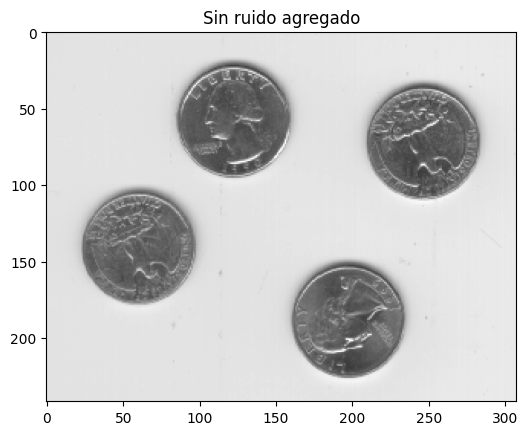

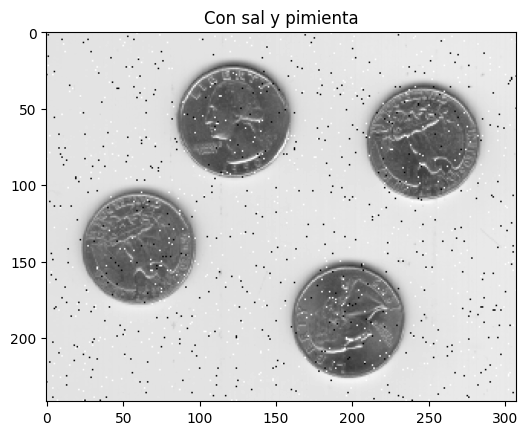

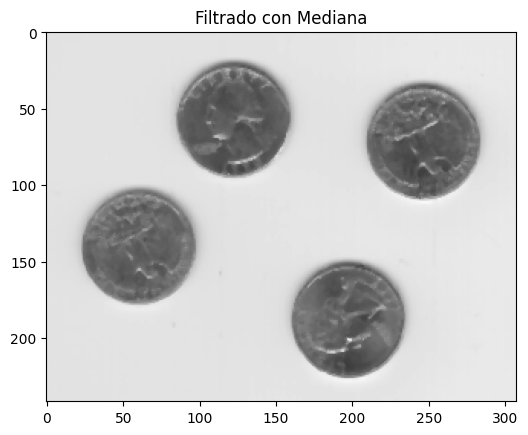

In [27]:
img = Image.open('images/eight.tif')
coins = np.array(img)

coins_with_salt_and_pepper = sal_y_pimienta(coins, 0.008)
coins_sp_median = median_filter(coins_with_salt_and_pepper, 3)

plt.figure()
plt.title('Sin ruido agregado')
plt.imshow(coins, cmap="gray", vmin=0, vmax=255)

plt.figure()
plt.title('Con sal y pimienta')
plt.imshow(coins_with_salt_and_pepper, cmap="gray", vmin=0, vmax=255)

plt.figure()
plt.title('Filtrado con Mediana')
plt.imshow(coins_sp_median, cmap="gray", vmin=0, vmax=255)


Como podemos ver, el filtro performa muy bien 

### 4) 

Laplaciano pasa altos:

In [16]:
def laplaciano_pasa_altos(img, dim=3):
    im = np.zeros((img.shape[0], img.shape[1]), dtype=float)
    pad = dim // 2

    def mask(sub_img, x, y):
      val = 0

      mask = np.array([[1, 1, 1], [1, -8 ,1], [1, 1, 1]])

      for i in range(dim):
        for j in range(dim):
          val += mask[i][j] * sub_img[i+x][j+y]
      return val

    dm = np.pad(img, pad, mode="edge")
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):
        im[i][j] = mask(dm, i, j)
    
    return im


Text(0.5, 1.0, 'Con filtro laplaciano')

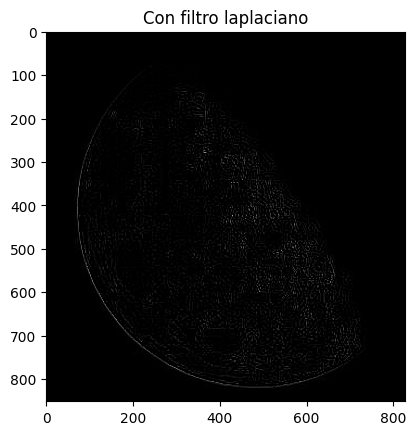

In [17]:
moon = cv2.imread('images/moon.png', cv2.IMREAD_GRAYSCALE)
ml = laplaciano_pasa_altos(moon)
plt.imshow(ml, cmap='gray', vmin=0, vmax=255)
plt.title("Con filtro laplaciano")


Y ahora volvemos a aplicar el contorno para que se vea la imagen completa pero con los detalles realzados

In [18]:
def laplaciano_con_background(img, dim=3):
  ni = np.zeros((img.shape[0], img.shape[1]), dtype=float)
  pad = dim // 2
  def mask(sub_img, x, y):
    val = 0
    mask = np.array([ [-1, -1, -1], [-1, 9 , -1], [-1, -1, -1]])
  
    for i in range(dim):
      for j in range(dim):
        val += mask[i][j] * sub_img[i+x][j+y]
    return val

  di = np.pad(img, pad, mode="edge")
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      ni[i][j] = mask(di, i, j)
  
  return ni


Text(0.5, 1.0, 'Laplace with background')

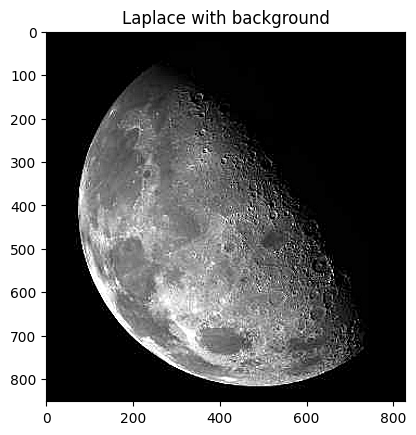

In [20]:
mlb = laplaciano_con_background(moon)
plt.imshow(mlb, cmap='gray', vmin=0, vmax=255)

### 5)
Hi-Boost
$$f_{hb} = A*f(x,y) - \bar{f}(x,y)$$

In [ ]:
img = cv2.imread("images/hiboost.png", cv2.IMREAD_GRAYSCALE) #Importamos la imagen
dimness = 0.2                                         #Parametro para setear oscurecemos la imagen
img = img- (np.amax(img)*dimness)                            #Oscurecemos la imagen original
hb_imgs=[]
amps = [1,1.3,1.5,1.7,2]                      #Valores de A a probar
for A in amps:
  hb_mask=[[-1, -1 , -1],
         [-1, A+8, -1],
         [-1,  -1, -1]]
  #hb_mask = normalize_mask(hb_mask)                    #Normalizamos la mascara
  hb_imgs.append(scipy.signal.convolve2d(img, hb_mask))#Convolucionamos con el kernel y agregamos a los resultados

#TOY FOR TEST
print("Ejemplo de la filmina; A=1 y A=1.7")
hb_imgs2 = []
hb_imgs2.append(hb_imgs[0])
hb_imgs2.append(hb_imgs[3])
show_side_by_side(hb_imgs2, ["Hi-Boost A= "+str(amps[0]),
                             "Hi-Boost A= "+str(amps[3])])
#TOY FOR TEST

In [ ]:
print("Algunos ejemplos más, variando el valor de A")
show_side_by_side(hb_imgs, [f"A={a}" for a in amps])

### 6) Filtrado en el dominio de la frecuencia: Filtro homomorfico


In [ ]:
## Función que emula el llamado en matlab a fspecial para hacer un filtro gaussiano
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h



In [ ]:
img = cv2.imread("images/tun.jpg", cv2.IMREAD_GRAYSCALE) #Importamos la imagen, f(x,y)
#
#Sumamos 1 para evitar que se nos explote el logaritmo
#Realmente no se porque no funciona lo siguiente
#iplus = np.array(img)
#iplus = iplus + 1.0
#Pero deberia ser asi y no con el for que esta aca abajo

#QUIERO TENER DE MINIMO UN 1!!!!!!!! 
w,h = img.shape
iplus = np.zeros(img.shape)
for x in range(w):
   for y in range(h):
    
     if img[x,y] < np.amin(img)+2:
      iplus[x,y] = 1
     else:
      iplus[x,y] = img[x,y] 
#print(img)
#AAAAAAAAAAAAAAAAAAAAAAA
#plt.imshow(iplus,cmap='gray', vmin=0, vmax=255)
#plt.title('iplus ')
#plt.axis('off')
#plt.show(block=False) #
logimg = np.zeros(img.shape)
logimg = np.log(iplus)                              #Tomamos el logaritmo de la imagen, z(x,y)=ln[f(x,y)]


In [ ]:
# function = (-1)^(x+y)
# Ensure the image and function have the same dimensions
height, width = logimg.shape
x, y = np.meshgrid(range(width), range(height))
function = (-1) ** (x + y)
# Multiply the image by the function; z' = z*(-1)^(x+y) a.k.a centramos el espectro de la imagen
shift_logimg = logimg*function

Z = scipy.fft.fft2(shift_logimg)                        #Transformamos, F{z(x,y)} = Z(u,v)

## DEFINO H(u,v)   
#H=np.ones(shift_logimg.shape) #NO FILTERING, test purposes
#matlab=matlab_style_gauss2D(shape=shift_logimg.shape,sigma=0.9)
#H = np.amax(Hmatlab) - Hmatlab
# Defino H como esta en la filmina
gamma_l = 1
gamma_h = 3
c = 1
D0 = 0.1
x, y = np.meshgrid(np.linspace(-1, 1, shift_logimg.shape[1]), np.linspace(-1, 1, shift_logimg.shape[0]))  # Espacio D
D = np.sqrt((x * x) + (y * y))
H = (gamma_h - gamma_l) * (1 - np.exp(-c * (D/ D0)**2)) + gamma_l

Zf = Z*H

# Antitransformo y me quedo con la parte real
s = np.real(scipy.fft.ifft2(Zf))
s= s * function                       # Invierto la trasformacion * (-1)^{x+y}
# Elevo y obtengo la imagen de salida
g = np.exp(s)
show_side_by_side([img,g], ["Original","Homeomorphic filtering"])

In [ ]:
#Visualizamos la transferencia de nuestro filtro y reconocemos que es un pasa altos.
print(H.shape)
plt.imshow(H,cmap='gray', vmin=0, vmax=np.amax(H))
plt.title('H ')
plt.axis('off')
plt.show(block=False) #
print(np.amax(H))
print(np.amin(H))

### 7) 

In [ ]:
# Load the image
image = cv2.imread('images/cameraman.tif', cv2.IMREAD_GRAYSCALE)
image = image[:,:]    #Para sacar filas/columnas
print(image.shape)
# Ensure the image and function have the same dimensions
height, width = image.shape
x, y = np.meshgrid(range(width), range(height))
function = (-1) ** (x + y)
# Multiply the image by the function
result_image = image*function
result_image.shape
plt.imshow(image,cmap='gray', vmin=0, vmax=255)
plt.title('Imagen original ')
plt.axis('off')
plt.show(block=False) #
plt.imshow(result_image,cmap='gray', vmin=0, vmax=255)
plt.title('Imagen*(-1)^{x+y}')
plt.axis('off')
plt.show(block=False) #

In [ ]:
Idft = np.conjugate(fft.fft2(result_image))   #Transformamos y conjugamos
i_out = fft.ifft2(Idft)*function
i_out = np.real(i_out)
i_out=i_out
plt.imshow(i_out,cmap='gray', vmin=0, vmax=255)
plt.title('Imagen de salida')
plt.axis('off')
plt.show(block=False) # Show the plot in non-blocking mode (i.e continue)

### Removemos una columna

In [ ]:
image_inv = image[:-1,:]    #Para sacar filas/columnas
function_inv = function [:-1,:]
Idft_inv = np.conjugate(fft.fft2(image_inv*function_inv))   #Transformamos y conjugamos
i_inv_out = np.real(fft.ifft2(Idft_inv)*function_inv) + 255     #Multiplicamos por (-1)^{x+y}, antitransformamos y recuperamos la parte real
                                                                #Sumamos el offset por tener valores negativos

plt.imshow(i_inv_out,cmap='gray', vmin=0, vmax=255)
plt.title('Imagen con una columna menos')
plt.axis('off')
plt.show(block=False) #